This notebook shows how to use TabPFN for tabular prediction with a scikit learn wrapper.

classifier = TabPFNClassifier(device='cpu')
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict(test_xs)

The fit function does not perform any computations, but only saves the training data. Computations are only done at inference time, when calling predict.
Note that the presaved models were trained for up to 100 features, 10 classes and 1000 samples. While the model does not have a hard bound on the number of samples, the features and classes are restricted and larger sizes lead to an error.

### Setup

In [156]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
import time
import torch
import numpy as np
import os

from scripts.model_builder import get_default_spec, save_model, load_model_only_inference
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, TabPFNClassifier
from scripts.differentiable_pfn_evaluation import eval_model, eval_model_range

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

from scripts import tabular_metrics
import random

In [158]:
base_path = '.'

### Load datasets

In [159]:
max_samples = 10000
n_samples = 10000

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
# test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

random.seed(0)
random.shuffle(cc_valid_datasets_multiclass)

Number of datasets: 30
Number of datasets: 150


In [160]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [161]:
model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
n_samples = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite='cc'), get_datasets('valid', task_type, suite='cc')

### Run on a single dataset

In [162]:
[(i, test_datasets[i][0]) for i in range(len(test_datasets))]

[(0, 'balance-scale'),
 (1, 'mfeat-fourier'),
 (2, 'breast-w'),
 (3, 'mfeat-karhunen'),
 (4, 'mfeat-morphological'),
 (5, 'mfeat-zernike'),
 (6, 'cmc'),
 (7, 'credit-approval'),
 (8, 'credit-g'),
 (9, 'diabetes'),
 (10, 'tic-tac-toe'),
 (11, 'vehicle'),
 (12, 'eucalyptus'),
 (13, 'analcatdata_authorship'),
 (14, 'analcatdata_dmft'),
 (15, 'pc4'),
 (16, 'pc3'),
 (17, 'kc2'),
 (18, 'pc1'),
 (19, 'banknote-authentication'),
 (20, 'blood-transfusion-service-center'),
 (21, 'ilpd'),
 (22, 'qsar-biodeg'),
 (23, 'wdbc'),
 (24, 'cylinder-bands'),
 (25, 'dresses-sales'),
 (26, 'MiceProtein'),
 (27, 'car'),
 (28, 'steel-plates-fault'),
 (29, 'climate-model-simulation-crashes')]

In [163]:
binary = cc_valid_datasets_multiclass_df.set_index("name").NumberOfClasses <= 2

In [164]:
[(i, valid_datasets[i][0], valid_datasets[i][1].shape) for i in range(len(valid_datasets))]

[(0, 'analcatdata_broadwaymult', torch.Size([285, 7])),
 (1, 'analcatdata_apnea2', torch.Size([475, 3])),
 (2, 'bodyfat', torch.Size([252, 14])),
 (3, 'robot-failures-lp5', torch.Size([164, 90])),
 (4, 'analcatdata_birthday', torch.Size([365, 3])),
 (5, 'wine', torch.Size([178, 13])),
 (6, 'autoMpg', torch.Size([398, 7])),
 (7, 'xd6', torch.Size([973, 9])),
 (8, 'thoracic-surgery', torch.Size([470, 16])),
 (9, 'backache', torch.Size([180, 31])),
 (10, 'autoPrice', torch.Size([159, 15])),
 (11, 'PizzaCutter3', torch.Size([1043, 37])),
 (12, 'SPECTF', torch.Size([349, 44])),
 (13, 'titanic', torch.Size([891, 7])),
 (14, 'synthetic_control', torch.Size([600, 60])),
 (15, 'Australian', torch.Size([690, 14])),
 (16, 'jEdit_4.0_4.2', torch.Size([274, 8])),
 (17, 'chscase_funds', torch.Size([185, 2])),
 (18, 'profb', torch.Size([672, 9])),
 (19, 'TuningSVMs', torch.Size([156, 80])),
 (20, 'PieChart3', torch.Size([1077, 37])),
 (21, 'parkinsons', torch.Size([195, 22])),
 (22, 'KnuggetChase3', 

In [165]:
ds = valid_datasets[149]
print(ds[0], ds[1].shape)
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]
classifier = TabPFNClassifier()
print(classifier)
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
print('AUC', float(roc), 'Cross Entropy', float(ce))

prnn_fglass torch.Size([214, 9])
loading model from file models_diff/prior_diff_real_checkpoint_download_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
TabPFNClassifier()
AUC 0.8962623951182305 Cross Entropy 0.4143409729003906


In [169]:
classifier = TabPFNClassifier( model_string="num_features_1000_multiclass_02_18_2023_05_40_39", epoch=100,  N_ensemble_configurations=32)
print(classifier)
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
print('AUC', float(roc), 'Cross Entropy', float(ce))

loading model from file models_diff/prior_diff_real_checkpoint_num_features_1000_multiclass_02_18_2023_05_40_39_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 26.29 M parameters
TabPFNClassifier(N_ensemble_configurations=32, epoch=100,
                 model_string='num_features_1000_multiclass_02_18_2023_05_40_39')
AUC 0.9035087719298246 Cross Entropy 0.4098496735095978


In [173]:
asdf = classifier.model[2].encoder

In [181]:
w = list(asdf.parameters())[0].detach().numpy()

Bad pipe message: %s [b'\x84\xe4\x80\x81\x10d\xb1\xf3\xc1.;9\xb4\x9a\x8b\xceuV y>\xa8\xf4\x9cer\x9c\x88\xe6\x02\x1e\xc9\xdb\x16\r\x1c:\x07\xde*Q\xbaV\x7f\xc63A[-\x05\xba\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00']
Bad pipe message: %s [b'_}\x1f\xac#\xf9\xaf2\xbf{\x80\x11\t\x1b%\xbbN\x8c \xbe\xdf']
Bad pipe message: %s [b's\x13M{_\xe4Y\xb2m\x8cw']
Bad pipe message: %s [b"\xb2X8\x19\xce\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x

In [150]:
classifier = TabPFNClassifier(model_string="featurewise_mlp_hidden_512_multiclass_02_16_2023_20_33_11", epoch=15,  N_ensemble_configurations=1)
print(classifier)
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
print('AUC', float(roc), 'Cross Entropy', float(ce))

loading model from file models_diff/prior_diff_real_checkpoint_featurewise_mlp_hidden_512_multiclass_02_16_2023_20_33_11_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 26.04 M parameters
TabPFNClassifier(N_ensemble_configurations=1, epoch=15,
                 model_string='featurewise_mlp_hidden_512_multiclass_02_16_2023_20_33_11')
AUC 0.5778032036613272 Cross Entropy 0.6607666015625


Bad pipe message: %s [b'\x02L\xc5\xd3iO\x9c\xa4\x1d#8n~)\xa5\x86d\x98 \x18\x86\xec\x04\x1dL\x97\xd4^\x1dfT\xae\x8e\x9a+\xfa\xde\xe0\xfe\xa0\x0b&\n\xc1,m\x1c\xaf<\xf45\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03']
Bad pipe message: %s [b'\x08\x07\x08\x08\x08', b'\n\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b'~\xce\xbf\xccD\xd5Qv\xc1\xabUw&\xb5\xcf\xbcD\x85\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\x0e\xc0\x04\x00/\x00\x96\x00A\x00\x07\xc0\x11\xc0\x07\xc0\x16\x00\x18\xc0\x0c\xc0\x02\x00\x05\x00\x04\xc0\x12\x

In [45]:
classifier.model[2].encoder

Linear(in_features=100, out_features=512, bias=True)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

N_ensemble_configurations = 32

classifiers =  [TabPFNClassifier(device='cuda', N_ensemble_configurations=N_ensemble_configurations)]
model_names = ["Theirs ensemble 32"]

classifiers.append(TabPFNClassifier(device='cuda', N_ensemble_configurations=4))
model_names.append("Theirs ensemble 4")

classifiers.append(TabPFNClassifier(device='cuda', N_ensemble_configurations=1))
model_names.append("Theirs ensemble 1")
#classifiers, model_names = [], []
model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=82, N_ensemble_configurations=N_ensemble_configurations))
model_names.append(f"Epoch 82 onehot ensemble 32")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=82, N_ensemble_configurations=4))
model_names.append(f"Epoch 82 onehot ensemble 4")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=82, N_ensemble_configurations=1))
model_names.append(f"Epoch 82 onehot ensemble 1")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=80, N_ensemble_configurations=N_ensemble_configurations))
model_names.append(f"Epoch 80 onehot ensemble 32")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=80, N_ensemble_configurations=4))
model_names.append(f"Epoch 80 onehot ensemble 4")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=80, N_ensemble_configurations=1))
model_names.append(f"Epoch 80 onehot ensemble 1")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=40, N_ensemble_configurations=N_ensemble_configurations))
model_names.append(f"Epoch 40 onehot ensemble 32")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=40, N_ensemble_configurations=4))
model_names.append(f"Epoch 40 onehot ensemble 4")

classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=40, N_ensemble_configurations=1))
model_names.append(f"Epoch 40 onehot ensemble 1")
# classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=26))
# model_names.append(f"Epoch 26 new")

classifiers.append(TabPFNClassifier(device='cuda', model_string="batch_64_aggregate_16_multiclass_02_01_2023_19_16_01", epoch=67, N_ensemble_configurations=N_ensemble_configurations))
model_names.append(f"Epoch 67 long good one ensemble 32")

classifiers.append(TabPFNClassifier(device='cuda', model_string="batch_64_aggregate_16_multiclass_02_01_2023_19_16_01", epoch=67, N_ensemble_configurations=4 ))
model_names.append(f"Epoch 67 long good one ensemble 4")

classifiers.append(TabPFNClassifier(device='cuda', model_string="batch_64_aggregate_16_multiclass_02_01_2023_19_16_01", epoch=67, N_ensemble_configurations=4 ))
model_names.append(f"Epoch 67 long good one ensemble 1")

# for i in range(0, 36, 5):
#     classifiers.append(TabPFNClassifier(device='cuda', model_string=model_string, epoch=i))
#     model_names.append(f"Epoch {i}")
    
results_new = {}
for i, ds in enumerate(valid_datasets):
    print(i, ds[0], ds[1].shape)
    xs, ys = ds[1].clone(), ds[2].clone()
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    aucs = []
    for classifier in classifiers:
        print(classifier)
        classifier.fit(train_xs, train_ys)
        prediction_ = classifier.predict_proba(test_xs)
        roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
        print('AUC', float(roc), 'Cross Entropy', float(ce))
        aucs.append(float(roc))
    results_new[ds[0]] = aucs



loading model from file models_diff/prior_diff_real_checkpoint_download_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
loading model from file models_diff/prior_diff_real_checkpoint_download_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
loading model from file models_diff/prior_diff_real_checkpoint_download_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
loading model from file models_diff/prior_diff_real_checkpoint_defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16_n_0_epoch_82.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.83 M parameters
loading model from file models_diff/prior_diff_real_checkpoint_defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16_n_0_epoch_82.cpkt
Loading model that can be used 

IndexError: Target 6 is out of bounds.

In [16]:
import pandas as pd
results_new_df_ensembling = pd.DataFrame.from_dict(results_new, orient='index', columns=model_names)
results_new_df_ensembling

Theirs ensemble 32  \
analcatdata_broadwaymult                                   0.748677   
analcatdata_apnea2                                         0.940023   
bodyfat                                                    0.997976   
robot-failures-lp5                                         0.934299   
analcatdata_birthday                                       0.921796   
wine                                                       0.999831   
autoMpg                                                    0.978863   
xd6                                                        1.000000   
thoracic-surgery                                           0.595477   
backache                                                   0.654321   
autoPrice                                                  1.000000   
PizzaCutter3                                               0.833959   
SPECTF                                                     0.891825   
titanic                                                    0.878249   
synthetic_control                                          0.999910   
Australian                                                 0.929877   
jEdit_4.0_4.2                                              0.848912   
chscase_funds                                              0.611395   
profb                                                      0.648161   
TuningSVMs                                                 0.669286   
PieChart3                                                  0.841292   
parkinsons                                                 0.985897   
KnuggetChase3                                              0.776471   
tae                                                        0.637708   
cleveland                                                  0.888889   
SPECT                                                      0.814690   
colleges_usnews                                            0.835559   
jEdit_4.2_4.3                                              0.717218   
sonar                                                      0.940476   
monks-problems-3                                           0.991202   
chscase_census3                                            0.487118   
wisconsin                                                  0.639744   
grub-damage                                                0.674286   
analcatdata_draft                                          0.413095   
socmob                                                     0.976655   
LED-display-domain-7digit                                  0.926629   
breast-cancer-dropped-missing-attributes-values            0.723494   
mofn-3-7-10                                                1.000000   
fishcatch                                                  0.997097   
analcatdata_halloffame                                     0.950398   
monks-problems-1                                           0.997878   
PieChart1                                                  0.862252   
regime_alimentaire                                         0.957738   
lungcancer_GSE31210                                        0.836985   
biomed                                                     0.964177   
analcatdata_wildcat                                        0.821549   
pbcseq                                                     0.859790   
cholesterol                                                0.663565   
heart-statlog                                              0.888202   
MegaWatt1                                                  0.682888   
meta                                                       0.766344   
servo                                                      0.943320   
haberman                                                   0.773183   

                                                 Theirs ensemble 4  \
analcatdata_broadwaymult                                  0.732830   
analcatdata_apnea2                                        0.933679   
body

In [17]:
results_new_df_ensembling.to_csv("ensemble_comparison_fixed.csv")

/anaconda/envs/tabpfn/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/anaconda/envs/tabpfn/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

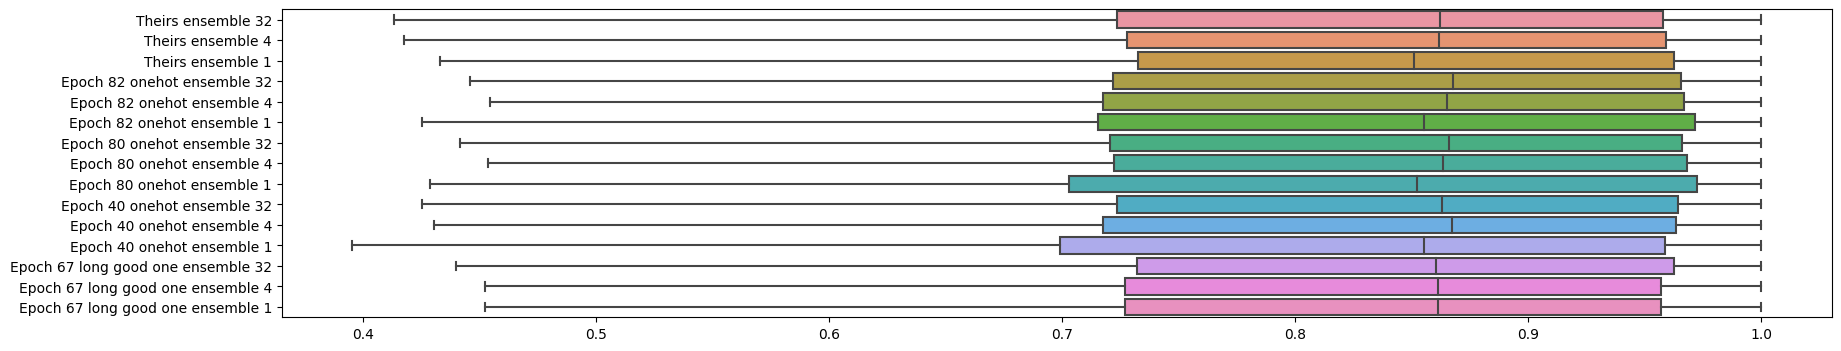

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 4))
ax = plt.gca()
sns.boxplot(data=results_new_df_ensembling, ax=ax, orient="h")

In [107]:
bla = old_results.join(results_new_df)

<AxesSubplot:>

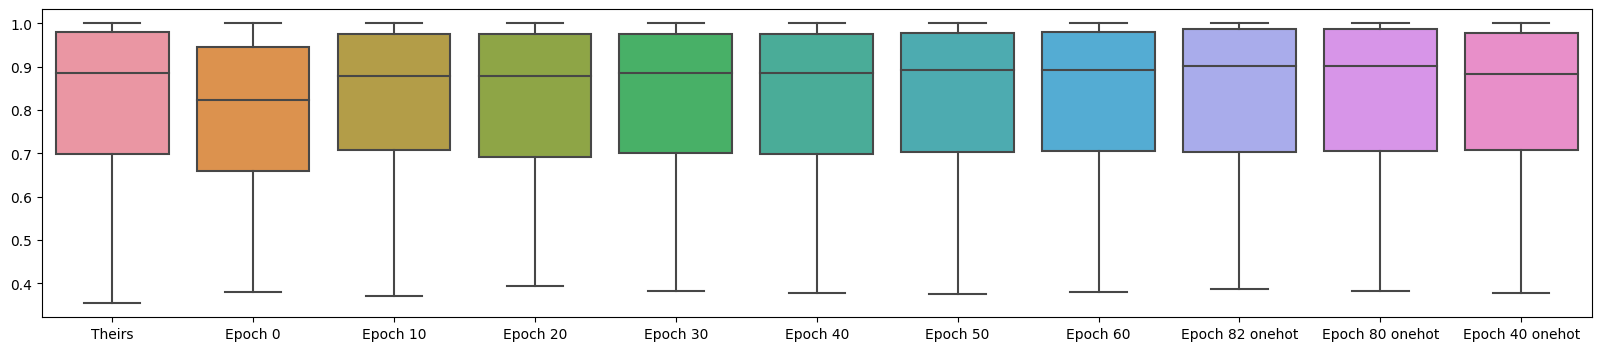

In [110]:
plt.figure(figsize=(20, 4))
ax = plt.gca()
sns.boxplot(data=bla, ax=ax)

In [111]:
(bla['Epoch 82 onehot'] < bla['Epoch 80 onehot']).mean()

0.3877551020408163

In [112]:
(bla['Epoch 82 onehot'] > bla['Epoch 80 onehot']).mean()

0.47619047619047616

In [113]:
(bla['Epoch 82 onehot'] > bla['Theirs']).mean()


0.6054421768707483

In [116]:
(bla['Epoch 60'] > bla['Theirs']).mean()


0.4965986394557823

In [117]:
(bla['Epoch 60'] < bla['Theirs']).mean()


0.4013605442176871

In [114]:
(bla['Epoch 82 onehot'] < bla['Theirs']).mean()


0.3333333333333333

<AxesSubplot:>

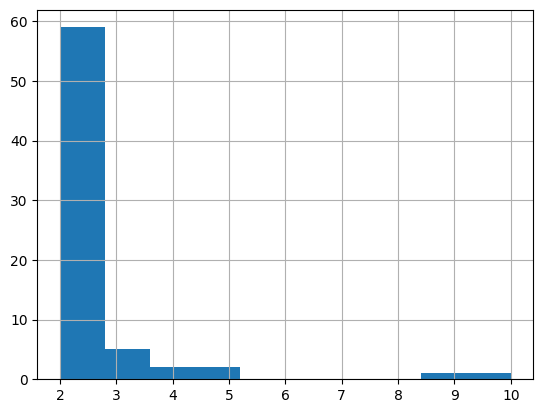

In [120]:
bla[bla['Epoch 60'] >= bla['Epoch 82 onehot']][['Theirs', 'Epoch 60', 'Epoch 82 onehot']].join(cc_valid_datasets_multiclass_df.set_index("name")).NumberOfClasses.hist()

<AxesSubplot:>

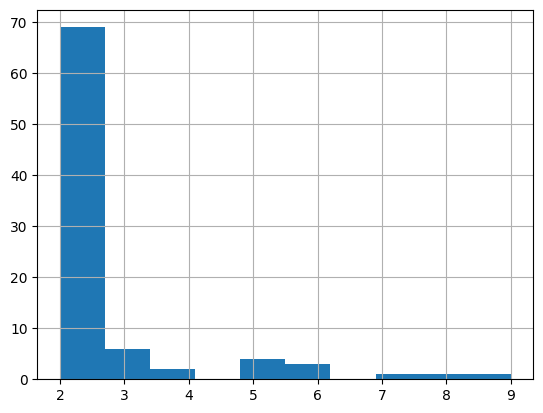

In [119]:
bla[bla['Epoch 60'] <= bla['Epoch 82 onehot']][['Theirs', 'Epoch 60', 'Epoch 82 onehot']].join(cc_valid_datasets_multiclass_df.set_index("name")).NumberOfClasses.hist()

/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

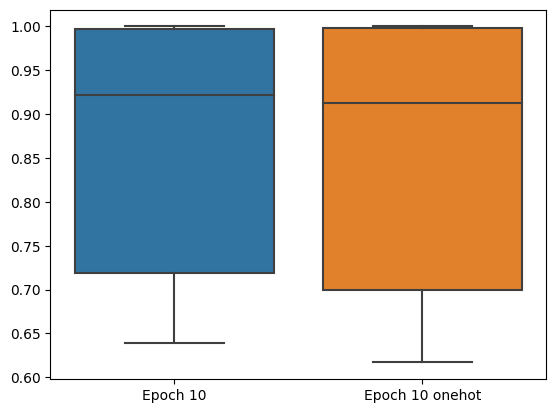

In [53]:
sns.boxplot(data=bla[~binary][['Epoch 10', 'Epoch 10 onehot']])

/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

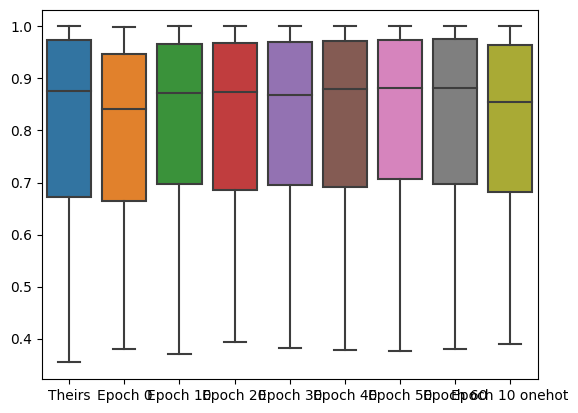

In [52]:
sns.boxplot(data=bla[binary])

In [67]:
bla

Theirs   Epoch 0  Epoch 10  Epoch 20  Epoch 30  \
analcatdata_broadwaymult  0.732787  0.646510  0.700615  0.715541  0.719667   
analcatdata_apnea2        0.932670  0.733708  0.906574  0.914504  0.927768   
bodyfat                   0.997976  0.958007  0.996964  0.998482  0.998229   
robot-failures-lp5        0.929639  0.534081  0.857367  0.909360  0.914569   
analcatdata_birthday      0.921513  0.897233  0.914737  0.916714  0.920949   
...                            ...       ...       ...       ...       ...   
corral                    1.000000  0.995443  1.000000  1.000000  1.000000   
sensory                   0.585400  0.583496  0.587793  0.557959  0.604102   
hepatitis                 0.864919  0.878024  0.845766  0.856855  0.854839   
PizzaCutter1              0.903996  0.843811  0.897052  0.902900  0.894128   
prnn_fglass               0.896262  0.844775  0.861175  0.874523  0.885584   

                          Epoch 40  Epoch 50  Epoch 60  Epoch 11 onehot  
analcatdata_broadwaymult  0.707136  0.727162  0.716788         0.672719  
analcatdata_apnea2        0.954152  0.952134  0.955882         0.886822  
bodyfat                   0.998482  0.997976  0.998229         0.980268  
robot-failures-lp5        0.923155  0.928421  0.933774         0.891380  
analcatdata_birthday      0.921796  0.925748  0.925466         0.915020  
...                            ...       ...       ...              ...  
corral                    1.000000  1.000000  1.000000         1.000000  
sensory                   0.597705  0.591357  0.597705         0.607275  
hepatitis                 0.868952  0.875000  0.871976         0.856855  
PizzaCutter1              0.900585  0.902656  0.895955         0.897052  
prnn_fglass               0.885584  0.895118  0.896262         0.861556  

[147 rows x 9 columns]

Bad pipe message: %s [b'~\xef\xf9\t\xc7\xf68"i\xa4M\xc3\xd1\x8f:\xc2WM \xbe\xcf\x95\xca\x9b\xbd\xb9\xfb0\xac\xba\xe0\xd9g\x9d\xee\x14\x18\xad\tz\xef\x05)SH\x7fjoM5\xa2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xa4u\x7f\x85\xad\xc4.\x81\x8d\xba(\x0f\x017s-]\xd6oq\x81\xd4m\xca]\xa9\xf1\x93\xc5gb']
Bad pipe message: %s [b"\xde\x00\xc6;{vE\xaa\x11\xe0\xe3\x98(|9\xb0\x11\x02\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@

<AxesSubplot:>

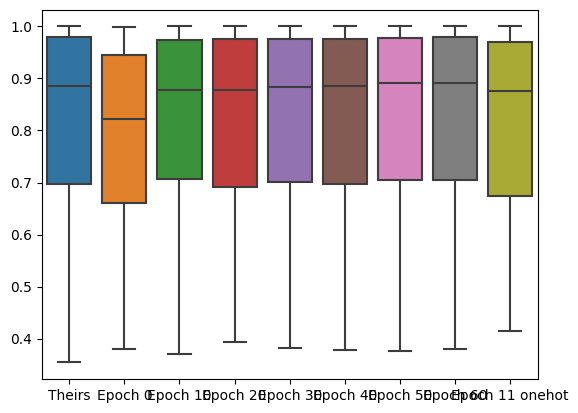

In [66]:
import seaborn as sns
#results_new = pd.DataFrame.from_dict(results_new,orient='index', columns=model_names)
sns.boxplot(data=bla)

In [95]:
sns.lineplot(data=results_new.T, legend=False)

<AxesSubplot:>

In [107]:
(results_new['Theirs'] > results_new['Epoch 19 new']).mean()

0.6394557823129252

Bad pipe message: %s [b'\x83\n\xfc\xcf\x0f\xa9c4\x1f\xfc\x1fOF\x13\xcb\xa6f\xdb 2\x85\x80\x12\xdf\xaa\xb9T\xa4kjkr\xb9U\xa0\x07\xd3\x1d\xbb\x0f\xde9\xc0\xcc\xe8\xb2\xedW\xbd\xc9z\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00']
Bad pipe message: %s [b'\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07']
Bad pipe message: %s [b'\xf8VM\x81O1\xbf\xc6b\xfa\xcc\xe3\xd3b\xdb\xb4\x9a\x86', b")\xb7\xc8\xe9\xb2\x9c\xe2\x03\xcc'\x90\xc3\x96_\xa5?\xfb\xa9\xef\xb22&Wj\xa4\xbaJ?\xa3-\x8d"]
Bad pipe message: %s [b'\x08\t\x08\n\x08\x0b\x08']
Bad pipe message: %s [b'\x05\x08\x06']
Bad pipe message: %s [b'\x05\x01\x06', b'']
Bad pipe message: %s [b"\xbb\xcfH\xa0X\x7f\xd9d\xcaJ\x99\xcaH\xaeGc\x8b\x7f\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/

In [ ]:
df_big_model = pd.DataFrame.from_dict(results_big_model,orient='index', columns=["Theirs", "Epoch 1", "Epoch 2", "Epoch 3", "new epoch 0", "mine"])

In [51]:
df_big_model

Theirs   Epoch 1   Epoch 2   Epoch 3  new epoch 0  \
analcatdata_broadwaymult  0.732787  0.722294  0.692624  0.716669     0.669683   
analcatdata_apnea2        0.932670  0.927191  0.891869  0.925606     0.793397   
bodyfat                   0.997976  0.982039  0.987857  0.991399     0.969643   
robot-failures-lp5        0.929639  0.835794  0.813660  0.820759     0.652081   
analcatdata_birthday      0.921513  0.909938  0.915020  0.913608     0.892998   
...                            ...       ...       ...       ...          ...   
corral                    1.000000  1.000000  1.000000  1.000000     0.998698   
sensory                   0.585400  0.603760  0.583643  0.600293     0.593457   
hepatitis                 0.864919  0.833669  0.852823  0.827621     0.845766   
PizzaCutter1              0.903996  0.896808  0.887183  0.890107     0.847344   
prnn_fglass               0.896262  0.868421  0.863082  0.863463     0.852021   

                              mine  
analcatdata_broadwaymult  0.716788  
analcatdata_apnea2        0.955882  
bodyfat                   0.998229  
robot-failures-lp5        0.933774  
analcatdata_birthday      0.925466  
...                            ...  
corral                    1.000000  
sensory                   0.597705  
hepatitis                 0.871976  
PizzaCutter1              0.895955  
prnn_fglass               0.896262  

[147 rows x 6 columns]

In [52]:
sns.boxplot(data=df_big_model)

<AxesSubplot:>

In [58]:
classifiers[-1].c

{'lr': 0.00010159069767993671,
 'dropout': 0.0,
 'emsize': 512,
 'batch_size': 32,
 'nlayers': 12,
 'num_features': 100,
 'nhead': 4,
 'nhid_factor': 2,
 'n_samples': 1152,
 'eval_positions': [1094],
 'n_samples_used': 50,
 'sampling': 'normal',
 'epochs': 800,
 'num_steps': 256,
 'verbose': False,
 'mix_activations': False,
 'pre_sample_causes': True,
 'multiclass_type': 'rank',
 'nan_prob_unknown_reason_reason_prior': 0.5,
 'categorical_feature_p': 0.2,
 'nan_prob_no_reason': 0.0,
 'nan_prob_unknown_reason': 0.0,
 'nan_prob_a_reason': 0.0,
 'max_num_classes': 10,
 'num_classes': '<function <lambda>.<locals>.<lambda> at 0x7fd08d6eac20>',
 'noise_type': 'Gaussian',
 'balanced': False,
 'normalize_to_ranking': False,
 'set_value_to_nan': 0.1,
 'normalize_by_used_features': True,
 'num_features_used': {'uniform_int_sampler_f(3,max_features)': '<function <lambda>.<locals>.<lambda> at 0x7fd08d6eab90>'},
 'num_categorical_features_sampler_a': -1.0,
 'differentiable_hyperparameters': {'prior

In [11]:
import pandas as pd
df = pd.DataFrame.from_dict(results_compare_steps,orient='index', columns=["Theirs", "Epoch 0", "Epoch 10", "Epoch 20", "Epoch 30", "Epoch 40", "Epoch 50", "Epoch 60"])
df

Theirs   Epoch 0  Epoch 10  Epoch 20  Epoch 30  \
analcatdata_broadwaymult  0.732787  0.646510  0.700615  0.715541  0.719667   
analcatdata_apnea2        0.932670  0.733708  0.906574  0.914504  0.927768   
bodyfat                   0.997976  0.958007  0.996964  0.998482  0.998229   
robot-failures-lp5        0.929639  0.534081  0.857367  0.909360  0.914569   
analcatdata_birthday      0.921513  0.897233  0.914737  0.916714  0.920949   
...                            ...       ...       ...       ...       ...   
corral                    1.000000  0.995443  1.000000  1.000000  1.000000   
sensory                   0.585400  0.583496  0.587793  0.557959  0.604102   
hepatitis                 0.864919  0.878024  0.845766  0.856855  0.854839   
PizzaCutter1              0.903996  0.843811  0.897052  0.902900  0.894128   
prnn_fglass               0.896262  0.844775  0.861175  0.874523  0.885584   

                          Epoch 40  Epoch 50  Epoch 60  
analcatdata_broadwaymult  0.707136  0.727162  0.716788  
analcatdata_apnea2        0.954152  0.952134  0.955882  
bodyfat                   0.998482  0.997976  0.998229  
robot-failures-lp5        0.923155  0.928421  0.933774  
analcatdata_birthday      0.921796  0.925748  0.925466  
...                            ...       ...       ...  
corral                    1.000000  1.000000  1.000000  
sensory                   0.597705  0.591357  0.597705  
hepatitis                 0.868952  0.875000  0.871976  
PizzaCutter1              0.900585  0.902656  0.895955  
prnn_fglass               0.885584  0.895118  0.896262  

[147 rows x 8 columns]

In [12]:
df.to_csv("learning_results_epoch_60.csv")

/anaconda/envs/tabpfn/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/anaconda/envs/tabpfn/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

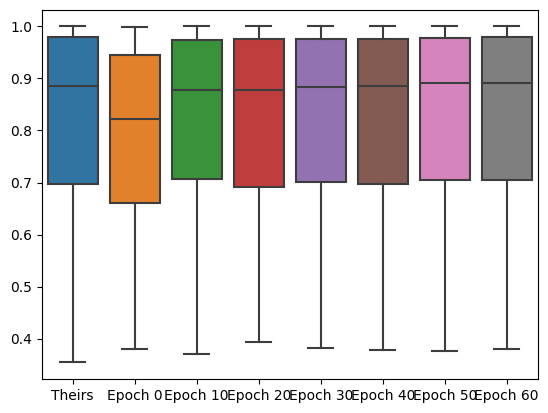

In [13]:
import seaborn as sns
sns.boxplot(data=df)

In [23]:
df.columns

Index(['Theirs', 'Epoch 0', 'Epoch 10', 'Epoch 20', 'Epoch 30', 'Epoch 40',
       'Epoch 50', 'Epoch 60', 'var'],
      dtype='object')

<AxesSubplot:>

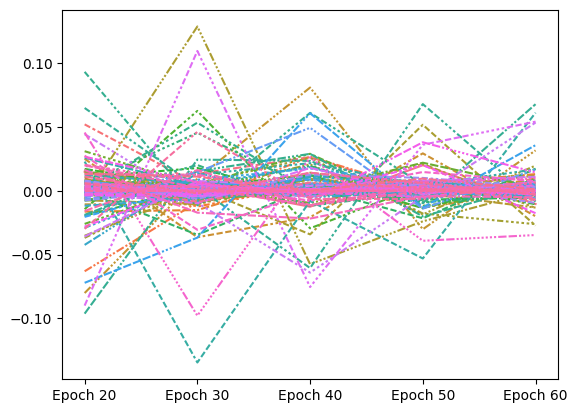

In [26]:
sns.lineplot(data=df[['Epoch 10', 'Epoch 20', 'Epoch 30', 'Epoch 40',
       'Epoch 50', 'Epoch 60']].T.diff(), legend=False)

In [29]:
bla = (df - df['Epoch 0']) / (df['Theirs'] - df['Epoch 0'])

In [45]:
bla.divide(bla.max(axis=1), axis="rows")

Theirs  Epoch 0  Epoch 10  Epoch 20  Epoch 30  \
analcatdata_broadwaymult  1.000000      0.0  0.627099  0.800105  0.847925   
analcatdata_apnea2        0.902551      0.0  0.784173  0.820144  0.880314   
bodyfat                   0.987500      0.0  0.962500  1.000000  0.993750   
robot-failures-lp5        0.991579      0.0  0.810409  0.940746  0.953804   
analcatdata_birthday      0.819048      0.0  0.590476  0.657143  0.800000   
...                            ...      ...       ...       ...       ...   
corral                    1.000000      0.0  1.000000  1.000000  1.000000   
sensory                   0.078629      0.0  0.177419 -1.054435  0.850806   
hepatitis                     -inf      NaN      -inf      -inf      -inf   
PizzaCutter1              1.000000      0.0  0.884615  0.981781  0.836032   
prnn_fglass               1.000000      0.0  0.318519  0.577778  0.792593   

                          Epoch 40  Epoch 49  
analcatdata_broadwaymult  0.702685  0.874791  
analcatdata_apnea2        1.000000  0.979725  
bodyfat                   1.000000  0.987500  
robot-failures-lp5        0.975325  1.000000  
analcatdata_birthday      0.828571  1.000000  
...                            ...       ...  
corral                    1.000000  1.000000  
sensory                   0.586694  1.000000  
hepatitis                     -inf      -inf  
PizzaCutter1              0.943320  0.886640  
prnn_fglass               0.792593  0.955556  

[147 rows x 7 columns]

<AxesSubplot:>

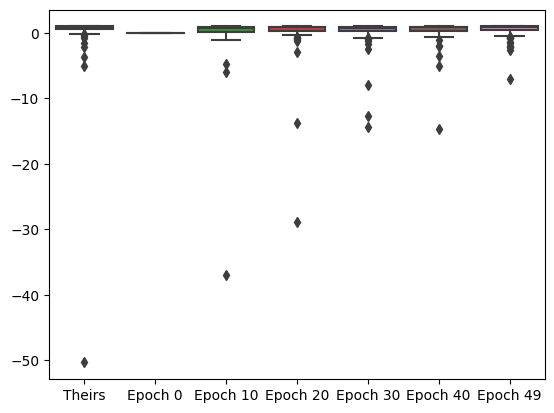

In [47]:
sns.boxplot(data=bla.divide(bla.max(axis=1), axis="rows"))

In [14]:
sns.lineplot(data=bla.divide(bla.max(axis=1), axis="rows").T, legend=False)

NameError: name 'bla' is not defined

In [60]:
df['var'] = df[['Theirs', 'Epoch 10', 'Epoch 20', 'Epoch 30', 'Epoch 40',
       'Epoch 49']].var(axis=1)

In [63]:
df.sort_values("var").tail(10)

Theirs   Epoch 0  Epoch 10  \
planning-relax                               0.353939  0.380000  0.370909   
chscase_census6                              0.485222  0.520628  0.490558   
thoracic-surgery                             0.617672  0.583194  0.613624   
analcatdata_apnea3                           0.843761  0.627179  0.766325   
KnuggetChase3                                0.800000  0.791176  0.750000   
chscase_census3                              0.454586  0.446316  0.469474   
pm10                                         0.558877  0.573564  0.493401   
parity5_plus_5                               0.433380  0.388273  0.547420   
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1  0.638571  0.587247  0.536727   
conference_attendance                        0.589198  0.400926  0.548457   

                                             Epoch 20  Epoch 30  Epoch 40  \
planning-relax                               0.435758  0.438788  0.378182   
chscase_census6                              0.418411  0.381671  0.442426   
thoracic-surgery                             0.550530  0.541597  0.568258   
analcatdata_apnea3                           0.859487  0.848034  0.909060   
KnuggetChase3                                0.669853  0.679412  0.760294   
chscase_census3                              0.463158  0.591880  0.534336   
pm10                                         0.403403  0.512940  0.437500   
parity5_plus_5                               0.593046  0.495164  0.521266   
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1  0.440432  0.464845  0.488248   
conference_attendance                        0.571296  0.436728  0.428704   

                                             Epoch 49       var  
planning-relax                               0.378182  0.001275  
chscase_census6                              0.421798  0.001761  
thoracic-surgery                             0.495812  0.002138  
analcatdata_apnea3                           0.903419  0.002665  
KnuggetChase3                                0.772059  0.002744  
chscase_census3                              0.486817  0.002829  
pm10                                         0.485443  0.003033  
parity5_plus_5                               0.465207  0.003304  
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1  0.510732  0.004907  
conference_attendance                        0.419444  0.006191

ModuleNotFoundError: No module named 'transformers'

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

results = {}
for i, ds in enumerate(valid_datasets):
    print(i, ds[0], ds[1].shape)
    xs, ys = ds[1].clone(), ds[2].clone()
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    aucs = []
    try:
        for classifier in [TabPFNClassifier(device='cuda'), make_pipeline(SimpleImputer(), RandomForestClassifier()), make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression(max_iter=1000))]:
            print(classifier)
            classifier.fit(train_xs, train_ys)
            prediction_ = classifier.predict_proba(test_xs)
            roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
            print('AUC', float(roc), 'Cross Entropy', float(ce))
            aucs.append(float(roc))
        results[ds[0]] = aucs
    except:
        continue

0 analcatdata_broadwaymult torch.Size([285, 7])
loading model from file models_diff/prior_diff_real_checkpoint_download_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
TabPFNClassifier(device='cuda')
AUC 0.7327873159845948 Cross Entropy 1.7826014757156372
Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])
AUC 0.7262253896267502 Cross Entropy 1.7829757928848267
Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])
AUC 0.6671846495490428 Cross Entropy 1.829662561416626
1 analcatdata_apnea2 torch.Size([475, 3])
loading model from file models_diff/prior_diff_real_checkpoint_download_n_0_epoch_100.cpkt
Loading model that can b

In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(results,orient='index', columns=["TabPFN", "RF", "LR"])

In [29]:
df.to_csv("validation_set_results.csv")

In [20]:
df['var'] = df.var(axis=1)

In [18]:
(df['Epoch 60'] - df['Epoch 50']).mean()

0.0020651659655601343

In [19]:
(df['Epoch 60'] - df['Epoch 50']).median()

0.0002482185003633841

In [22]:
df[df['var'] > 1e-5]

Theirs   Epoch 0  Epoch 10  Epoch 20  Epoch 30  \
analcatdata_broadwaymult  0.732787  0.646510  0.700615  0.715541  0.719667   
analcatdata_apnea2        0.932670  0.733708  0.906574  0.914504  0.927768   
bodyfat                   0.997976  0.958007  0.996964  0.998482  0.998229   
robot-failures-lp5        0.929639  0.534081  0.857367  0.909360  0.914569   
analcatdata_birthday      0.921513  0.897233  0.914737  0.916714  0.920949   
...                            ...       ...       ...       ...       ...   
vertebra-column           0.923295  0.877183  0.920094  0.925820  0.928551   
sensory                   0.585400  0.583496  0.587793  0.557959  0.604102   
hepatitis                 0.864919  0.878024  0.845766  0.856855  0.854839   
PizzaCutter1              0.903996  0.843811  0.897052  0.902900  0.894128   
prnn_fglass               0.896262  0.844775  0.861175  0.874523  0.885584   

                          Epoch 40  Epoch 50  Epoch 60       var  
analcatdata_broadwaymult  0.707136  0.727162  0.716788  0.000727  
analcatdata_apnea2        0.954152  0.952134  0.955882  0.005396  
bodyfat                   0.998482  0.997976  0.998229  0.000201  
robot-failures-lp5        0.923155  0.928421  0.933774  0.018613  
analcatdata_birthday      0.921796  0.925748  0.925466  0.000085  
...                            ...       ...       ...       ...  
vertebra-column           0.927475  0.928673  0.928922  0.000309  
sensory                   0.597705  0.591357  0.597705  0.000198  
hepatitis                 0.868952  0.875000  0.871976  0.000125  
PizzaCutter1              0.900585  0.902656  0.895955  0.000402  
prnn_fglass               0.885584  0.895118  0.896262  0.000349  

[126 rows x 9 columns]

In [66]:
df.to_csv("different_epoch_evals.csv")

In [67]:
val_results = pd.read_csv("validation_set_results.csv")

In [69]:
(val_results["TabPFN"] > val_results["RF"]).sum()

84

In [70]:
(val_results["TabPFN"] < val_results["RF"]).sum()

57

In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df.sort_values('var'))

TabPFN        RF  \
synthetic_control                                 0.999779  0.999524   
cpu                                               0.995641  0.995859   
dermatology                                       0.998958  0.999646   
wine                                              0.999831  0.998817   
thyroid-new                                       0.996962  0.996753   
auto_price                                        1.000000  0.999324   
tae                                               0.638304  0.639304   
mofn-3-7-10                                       1.000000  0.998002   
autoPrice                                         1.000000  1.000000   
heart-c                                           0.876307  0.874390   
mu284                                             0.999404  1.000000   
machine_cpu                                       0.989899  0.989689   
vote                                              0.995082  0.994900   
iris-example                                      0.995996  0.997853   
iris                                              0.995996  0.998390   
fishcatch                                         0.997097  0.994194   
chscase_whale                                     1.000000  1.000000   
penguins                                          0.999793  0.996214   
bodyfat                                           0.997976  0.996838   
visualizing_galaxy                                0.991952  0.990327   
autoMpg                                           0.979167  0.974059   
tokyo1                                            0.977874  0.976543   
PopularKids                                       0.626865  0.631729   
cleveland                                         0.889236  0.890885   
pwLinear                                          0.935471  0.930195   
seeds                                             0.999595  0.991573   
analcatdata_halloffame                            0.949247  0.940207   
chatfield_4                                       0.973953  0.967752   
wholesale-customers                               0.952593  0.952932   
Smartphone-Based_Recognition_of_Human_Activities  0.999148  0.997756   
servo                                             0.940081  0.944130   
pbc                                               0.762153  0.767322   
socmob                                            0.976331  0.978474   
Australian                                        0.928846  0.931801   
solar-flare                                       0.891497  0.894878   
rmftsa_ladata                                     0.964787  0.963252   
analcatdata_lawsuit                               0.999180  1.000000   
backache                                          0.655693  0.652949   
boston_corrected                                  0.960388  0.949029   
biomed                                            0.963415  0.962652   
DiabeticMellitus                                  0.981417  0.992761   
autoHorse                                         0.990242  0.997658   
titanic                                           0.876868  0.876739   
prnn_synth                                        0.923412  0.926998   
chscase_census6                                   0.485222  0.492508   
lungcancer_GSE31210                               0.840206  0.824098   
breast-cancer                                     0.697494  0.683083   
heart-statlog                                     0.885108  0.887539   
user-knowledge                                    0.953587  0.957223   
diggle_table_a2                                   1.000000  0.999746   
lowbwt                                            0.862299  0.878119   
cleveland-nominal                                 0.653420  0.639410   
CPMP-2015-runtime-classification                  0.711531  0.695019   
vertebra-column                                   0.923295  0.917107   
colleges_usnews                                   0.834104  0.826514   
profb               

In [34]:
df[df.TabPFN < df.LR]

TabPFN        RF        LR
analcatdata_birthday                             0.921513  0.907820  0.930830
wine                                             0.999831  0.998817  1.000000
synthetic_control                                0.999779  0.999524  0.999842
chscase_funds                                    0.603953  0.586512  0.615116
TuningSVMs                                       0.655000  0.671429  0.692857
tae                                              0.638304  0.639304  0.640464
chscase_census3                                  0.454586  0.472030  0.495038
grub-damage                                      0.673746  0.722703  0.697816
LED-display-domain-7digit                        0.924706  0.931162  0.950081
breast-cancer-dropped-missing-attributes-values  0.730214  0.696615  0.731956
fishcatch                                        0.997097  0.994194  0.997823
MegaWatt1                                        0.664706  0.668182  0.713369
servo                                            0.940081  0.944130  0.950607
dermatology                                      0.998958  0.999646  0.999384
mw1                                              0.680903  0.684642  0.725482
disclosure_x_bias                                0.547185  0.486950  0.564536
disclosure_x_noise                               0.505915  0.473163  0.509165
vinnie                                           0.925133  0.891360  0.927130
disclosure_z                                     0.536886  0.470458  0.551209
chscase_census4                                  0.458984  0.524010  0.463485
planning-relax                                   0.353939  0.447273  0.403030
visualizing_galaxy                               0.991952  0.990327  0.995821
conference_attendance                            0.589198  0.521605  0.606481
thyroid-new                                      0.996962  0.996753  0.998609
iris                                             0.995996  0.998390  0.999463
penguins                                         0.999793  0.996214  0.999864
heart-h                                          0.908470  0.888097  0.912284
pharynx                                          0.876644  0.853061  0.888435
mc2                                              0.663012  0.607456  0.692251
CPMP-2015-runtime-classification                 0.711531  0.695019  0.714116
iris-example                                     0.995996  0.997853  0.999463
machine_cpu                                      0.989899  0.989689  0.992003
cleveland-nominal                                0.653420  0.639410  0.657871
chscase_geyser1                                  0.913378  0.882609  0.924080
chatfield_4                                      0.973953  0.967752  0.977364
parity5_plus_5                                   0.433380  0.655762  0.436460
triazines                                        0.757189  0.862941  0.764610
heart-long-beach                                 0.662116  0.592679  0.676615
vertebra-column                                  0.923295  0.917107  0.937802

In [42]:
df[df.TabPFN < df.RF].sort_values("TabPFN")

TabPFN        RF        LR           var
planning-relax             0.353939  0.447273  0.403030  2.179737e-03
analcatdata_draft          0.428968  0.582738  0.412698  8.803894e-03
parity5_plus_5             0.433380  0.655762  0.436460  1.625940e-02
chscase_census3            0.454586  0.472030  0.495038  4.116532e-04
chscase_census4            0.458984  0.524010  0.463485  1.318638e-03
chscase_census6            0.485222  0.492508  0.476293  6.595711e-05
analcatdata_gsssexsurvey   0.508197  0.564280  0.507334  1.064806e-03
pm10                       0.558877  0.625970  0.473473  5.841803e-03
plasma_retinol             0.563704  0.591630  0.547353  5.012821e-04
sensory                    0.585400  0.673462  0.520410  5.900567e-03
schizo                     0.597591  0.722038  0.582503  5.864088e-03
PopularKids                0.626865  0.631729  0.624121  1.484373e-05
no2                        0.634535  0.716760  0.621554  2.665600e-03
tae                        0.638304  0.639304  0.640464  1.169057e-06
TuningSVMs                 0.655000  0.671429  0.692857  3.603741e-04
MegaWatt1                  0.664706  0.668182  0.713369  7.370099e-04
grub-damage                0.673746  0.722703  0.697816  5.992441e-04
mw1                        0.680903  0.684642  0.725482  6.115209e-04
teachingAssistant          0.698542  0.766566  0.695945  1.603535e-03
triazines                  0.757189  0.862941  0.764610  3.484544e-03
pbc                        0.762153  0.767322  0.756472  2.944880e-05
analcatdata_wildcat        0.835690  0.862626  0.822896  4.112959e-04
analcatdata_apnea3         0.843761  0.867607  0.375214  7.709266e-02
analcatdata_apnea1         0.843920  0.896882  0.558159  3.319963e-02
pbcseq                     0.855606  0.872499  0.774321  2.755288e-03
colic                      0.860074  0.892936  0.835258  8.370875e-04
lowbwt                     0.862299  0.878119  0.861408  8.838847e-05
hepatitis                  0.864919  0.890625  0.782258  3.206177e-03
heart-statlog              0.885108  0.887539  0.871189  7.783054e-05
SPECTF                     0.886011  0.913143  0.865398  5.734347e-04
cleveland                  0.889236  0.890885  0.883333  1.576616e-05
solar-flare                0.891497  0.894878  0.883342  3.516779e-05
cleve                      0.902029  0.917375  0.883995  2.791510e-04
prnn_synth                 0.923412  0.926998  0.912141  6.010019e-05
LED-display-domain-7digit  0.924706  0.931162  0.950081  1.739179e-04
Australian                 0.928846  0.931801  0.921116  3.044331e-05
robot-failures-lp5         0.929639  0.932116  0.644454  2.734773e-02
analcatdata_apnea2         0.932670  0.942258  0.537341  5.338900e-02
servo                      0.940081  0.944130  0.950607  2.819256e-05
rmftsa_ctoarrivals         0.940175  0.952065  0.829287  4.585368e-03
wholesale-customers        0.952593  0.952932  0.944079  2.516157e-05
water-treatment            0.953512  0.977428  0.765289  1.350043e-02
user-knowledge             0.953587  0.957223  0.939766  8.483636e-05
regime_alimentaire         0.962500  0.981250  0.940476  4.165190e-04
kdd_el_nino-small          0.971247  0.983752  0.931818  7.346816e-04
collins                    0.974167  1.000000  0.965595  3.207530e-04
socmob                     0.976331  0.978474  0.968168  2.957423e-05
DiabeticMellitus           0.981417  0.992761  0.979473  5.150949e-05
ionosphere                 0.982003  0.982561  0.902762  2.107893e-03
autoHorse                  0.990242  0.997658  0.982826  5.499826e-05
stock                      0.993298  0.993998  0.922660  1.679910e-03
cpu                        0.995641  0.995859  0.995205  1.108485e-07
iris                       0.995996  0.998390  0.999463  3.151232e-06
iris-example               0.995996  0.997853  0.999463  3.011014e-06
dermatology                0.998958  0.999646  0.999384  1.203762e-07
analcatdata_lawsuit        0.999180  1.000000  0.988525  4.098361e-05
mu284                      0.999404  1.

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.sort_values("LR"))

                                                    TabPFN        RF        LR
analcatdata_apnea3                                0.843761  0.867607  0.375214
planning-relax                                    0.353939  0.447273  0.403030
analcatdata_draft                                 0.428968  0.582738  0.412698
parity5_plus_5                                    0.433380  0.655762  0.436460
chscase_census5                                   0.527811  0.469338  0.456182
chscase_census4                                   0.458984  0.524010  0.463485
pm10                                              0.558877  0.625970  0.473473
chscase_census6                                   0.485222  0.492508  0.476293
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1       0.638571  0.603144  0.491872
chscase_census3                                   0.454586  0.472030  0.495038
analcatdata_vineyard                              0.870674  0.865115  0.496850
chscase_vine2                                     0.

In [46]:
[(i, n[0]) for i, n in enumerate(valid_datasets)]

[(0, 'analcatdata_broadwaymult'),
 (1, 'analcatdata_apnea2'),
 (2, 'bodyfat'),
 (3, 'robot-failures-lp5'),
 (4, 'analcatdata_birthday'),
 (5, 'wine'),
 (6, 'autoMpg'),
 (7, 'xd6'),
 (8, 'thoracic-surgery'),
 (9, 'backache'),
 (10, 'autoPrice'),
 (11, 'PizzaCutter3'),
 (12, 'SPECTF'),
 (13, 'titanic'),
 (14, 'synthetic_control'),
 (15, 'Australian'),
 (16, 'jEdit_4.0_4.2'),
 (17, 'chscase_funds'),
 (18, 'profb'),
 (19, 'TuningSVMs'),
 (20, 'PieChart3'),
 (21, 'parkinsons'),
 (22, 'KnuggetChase3'),
 (23, 'tae'),
 (24, 'cleveland'),
 (25, 'SPECT'),
 (26, 'colleges_usnews'),
 (27, 'jEdit_4.2_4.3'),
 (28, 'sonar'),
 (29, 'monks-problems-3'),
 (30, 'chscase_census3'),
 (31, 'wisconsin'),
 (32, 'grub-damage'),
 (33, 'analcatdata_draft'),
 (34, 'socmob'),
 (35, 'LED-display-domain-7digit'),
 (36, 'breast-cancer-dropped-missing-attributes-values'),
 (37, 'mofn-3-7-10'),
 (38, 'fishcatch'),
 (39, 'analcatdata_halloffame'),
 (40, 'monks-problems-1'),
 (41, 'PieChart1'),
 (42, 'regime_alimentaire'

In [29]:
evaluation_dataset_index = 149 # Index of the dataset to predict
ds = valid_datasets[evaluation_dataset_index]
print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape}')

NameError: name 'valid_datasets' is not defined

In [60]:
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]

In [61]:
eval_position

107

In [62]:
classifier = TabPFNClassifier(device='cuda')
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)

loading model from file models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [63]:
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

('AUC', 0.8962623951182305, 'Cross Entropy', 0.4143429696559906)

In [64]:
model_string = "batch_default_short_4_gpu_try_again_multiclass_01_30_2023_22_11_16"
classifier = TabPFNClassifier(device='cuda', model_string=model_string, epoch=0)
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

loading model from file models_diff/prior_diff_real_checkpointbatch_default_short_4_gpu_try_again_multiclass_01_30_2023_22_11_16_n_0_epoch_0.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


('AUC', 0.8203661327231122, 'Cross Entropy', 0.513288676738739)

In [65]:
model_string = "_batch_128_long_multiclass_01_31_2023_01_08_24"
classifier = TabPFNClassifier(device='cuda', model_string=model_string, epoch="0")
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

loading model from file models_diff/prior_diff_real_checkpoint_batch_128_long_multiclass_01_31_2023_01_08_24_n_0_epoch_0.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


('AUC', 0.8592677345537757, 'Cross Entropy', 0.4721548855304718)

In [66]:
model_string = "_batch_128_long_multiclass_01_31_2023_01_08_24"
classifier = TabPFNClassifier(device='cuda', model_string=model_string, epoch="10")
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

loading model from file models_diff/prior_diff_real_checkpoint_batch_128_long_multiclass_01_31_2023_01_08_24_n_0_epoch_10.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


('AUC', 0.8749046529366895, 'Cross Entropy', 0.4384596049785614)

In [14]:
model_string = 
classifier = TabPFNClassifier(device='cuda', model_string="batch_64_aggregate_16_multiclass_02_01_2023_19_16_01", epoch="49")
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

loading model from file models_diff/prior_diff_real_checkpoint_batch_64_aggregate_16_multiclass_02_01_2023_19_16_01_n_0_epoch_49.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


('AUC', 0.8939740655987795, 'Cross Entropy', 0.41015931963920593)

Bad pipe message: %s [b'']
Bad pipe message: %s [b'o\x92\xd5\xc9\xca\xb6\x7f\x95\x0c\xbdy\x00w', b'` \x9cu\x91\xa1A\x90w\xf9\xe3npP\xd4\x12\x1bu.\xc0\x13\xab\xe4\x9b\xb8\x9f\xfb^\x99\xf69jJ\xd8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n']
Bad pipe message: %s [b'\xe2\x81\xe6v\x8bX{P\x82\xa5~\xaat\xc7\x01\xed\x94\xd1\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\x0e\xc0\x04\x00/\x00\x96\x00A\x00\x07\xc0\x11\xc0\x07\xc0\x16\x00\x18\xc0\x0c\xc0\x02\x00\x05\x00\x04\xc0\x12\xc0\x08\x00\x16\x00\x13\x00\x10\x00\r\xc0\x17\x00\x1b\xc0\r\xc0\x03\x00\n\x00\x15\x00\x12\x00\x0f\x00\x0c\x00\x1a\x00\t\x00\x14\x00\x11\x00\x19\x00\x08\x00\x06\x00\x17\x00\x03\xc0\x10\xc0\x06\xc0\x15\xc0\x0b\xc0\x01\x00\x02\x00\x01\x0

In [68]:
model_string = "_batch_128_long_multiclass_01_31_2023_01_08_24"
classifier = TabPFNClassifier(device='cuda', model_string=model_string, epoch="28")
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

loading model from file models_diff/prior_diff_real_checkpoint_batch_128_long_multiclass_01_31_2023_01_08_24_n_0_epoch_28.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


('AUC', 0.8924485125858124, 'Cross Entropy', 0.4122483432292938)

In [69]:
import lightgbm
classifier = lightgbm.LGBMClassifier()
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

KeyboardInterrupt: 

In [56]:
import sklearn
sklearn.__version__

'0.24.2'

In [68]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

('AUC', 0.812632779919742, 'Cross Entropy', 0.46891576051712036)

In [71]:
from sklearn.linear_model import LogisticRegressionCV
classifier = LogisticRegressionCV(max_iter=1000)
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

('AUC', 0.7750609804075852, 'Cross Entropy', 0.49685361981391907)

### Run on all datasets
This section runs a differentiable hyperparameter tuning run and saves the results to a results file, which can be inserted in TabularEval.ipynb to compare to other baselines.

In [ ]:
eval_positions=[1000]
n_samples=2000

N_models = 3
models_per_block = 1

eval_addition = 'user_run'
device = 'cpu'

eval_model_range(i_range=[0], e=-1
                          , valid_datasets=[]#cc_valid_datasets_multiclass
                          , test_datasets=cc_test_datasets_multiclass
                          , train_datasets=[]
                          , eval_positions_test=eval_positions
                          , n_samples_test=n_samples
                          , add_name=model_string
                          , base_path=base_path
                          , selection_metric='auc'
                          , best_grad_steps=0
                          , eval_addition=eval_addition
                          , N_ensemble_configurations_list = [32]
                          , device=device)#range(0, 10)

### Run generalization experiments

In [ ]:
# Loading longer OpenML Datasets for generalization experiments (optional)
test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


In [ ]:
test_datasets_longer_generalization = [ds for ds in test_datasets_multiclass if ds[1].shape[0] >= 10000]

In [ ]:
def test_gen(classifier_key, split):
    ces = []
    for k in tqdm(range(0, len(test_datasets_longer_generalization))):
        x, y = test_datasets_longer_generalization[k][1], test_datasets_longer_generalization[k][2].numpy()
        x = normalize_data(x).numpy()
        x[np.isnan(x)] = 0.0
        print(x.shape[0])
        
        if x.shape[0] < 10000:
            continue
        if len(np.unique(y)) > 2:
            continue

        for n_samples_ in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]:
            n_samples_ = n_samples_ // 2
            #model = classifier_dict[classifier_key]
            x_, y_ = x.copy(), y.copy()
            x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.5, random_state=split)
            x_train, y_train = x_train[0:n_samples_], y_train[0:n_samples_]
            model.fit(x_train, y_train) # ranking[0:j]
            pred = model.predict_proba(x_test) # ranking[0:j]
            ce = tabular_metrics.auc_metric(y_test, pred)
            ces += [{'n_samples': n_samples_, 'k': k, 'm': float(ce), 'method': classifier_key, 'split': split}]
            print(x_train.shape, ce)
    with open(f'generalization_{classifier_key}_{split}.obj',"wb") as fh:
        pickle.dump(ces,fh)

In [ ]:
test_gen('tabpfn', 0)

In [ ]:
ces = []
for classifier_key in classifier_dict:
    for split in range(0,5):
        try:
            with open(f'generalization_{classifier_key}_{split}.obj',"rb") as fh:
                ces += pickle.load(fh)
        except:
            pass
df = pd.DataFrame(ces)

In [ ]:
df = df.groupby(['n_samples', 'split', 'method']).mean().reset_index()
fig, ax = plt.subplots(1,1, figsize=(8, 6)) # , sharey=True

colors = iter(sns.color_palette("tab10"))
for classifier_key in ['tabpfn']:#df.method.unique():
    c = next(colors)
    sns.lineplot(x='n_samples', y='m', data=df[df.method==classifier_key], label=relabeler[classifier_key], color=c, ax = ax)
    #ax.text(x = df[df.method==classifier_key].iloc[50].n_samples, # x-coordinate position of data label
    # y = df[df.method==classifier_key].iloc[50].m, # y-coordinate position of data label, adjusted to be 150 below the data point
    # s = classifier_key, # data label, formatted to ignore decimals
    # color = c, size=12) # set colour of line
    
ax.get_legend().remove()
ax.set(xlabel='Number of training samples')
ax.set(ylabel='ROC AUC')
plt.axvline(x=1024, linestyle='dashed', color='red')
plt.ylim((0.73,0.79))
plt.xlim((250,5000))

In [61]:
with open("big_model_k_aggregate_4_lr0005") as f:
    log = f.read()

In [63]:
import re
losses = [float(v) for v in re.findall('mean loss (.*) \|', log)]

<>:2: DeprecationWarning: invalid escape sequence \|
<>:2: DeprecationWarning: invalid escape sequence \|
<>:2: DeprecationWarning: invalid escape sequence \|
/tmp/ipykernel_460427/2857500567.py:2: DeprecationWarning: invalid escape sequence \|
  losses = [float(v) for v in re.findall('mean loss (.*) \|', log)]


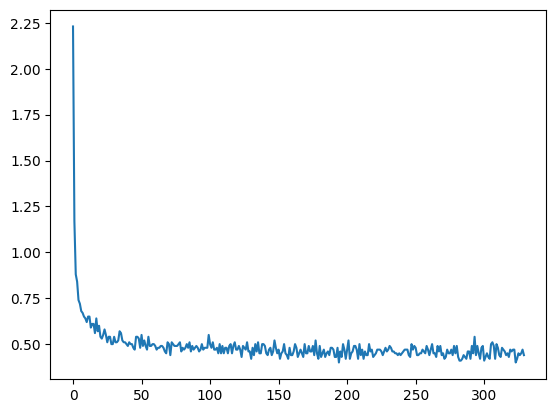

In [69]:
import matplotlib.pyplot as plt
plt.plot(losses)

(0.44, 0.5)

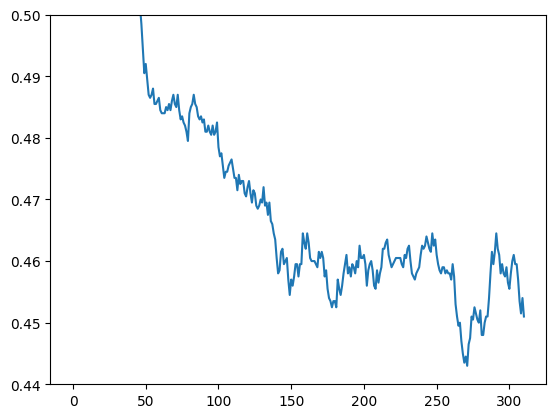

In [79]:
plt.plot(np.convolve(losses, np.ones(20) / 20., 'valid'))
plt.ylim(.44, .5)

<>:3: DeprecationWarning: invalid escape sequence \|
<>:3: DeprecationWarning: invalid escape sequence \|
<>:3: DeprecationWarning: invalid escape sequence \|
/tmp/ipykernel_460427/509578750.py:3: DeprecationWarning: invalid escape sequence \|
  losses = [float(v) for v in re.findall('mean loss (.*) \|', log)]


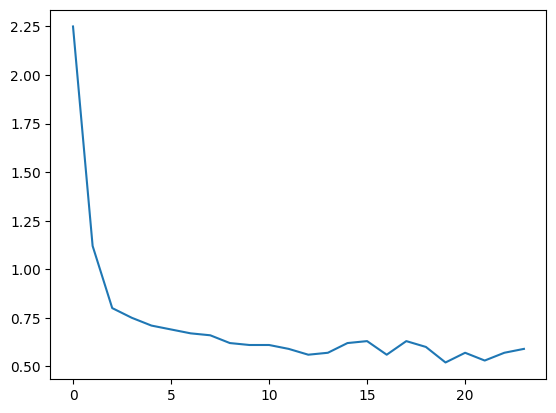

Bad pipe message: %s [b'"\x13U\n\xc9\x04\xa4\xd1\x9c>\x80\x95\x8dJ\xd5\x85\xde\xaf  T\xa8\xcf2<K|\xee{\xec$,M\xc6r\xfb;5\x94Es6\xc0q\xe7\xf9\x86\x9e\xa9&\xa0\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xb7\xea5Y<\x8f\x0f\n\xd4;n\x86S\xa0\xdc.\x80_\x88\x00\r\x9b']
Bad pipe message: %s [b'\x01\x1a\xf0r#\x18\xe8cw\x9f\x07\xa0\x8c+\x01\x01\xb9*\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc', b"\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00

In [87]:
with open("n_layers_2_emsize_1024_lr0001") as f:
    log = f.read()
losses = [float(v) for v in re.findall('mean loss (.*) \|', log)]
plt.plot(losses)

<>:3: DeprecationWarning: invalid escape sequence \|
<>:3: DeprecationWarning: invalid escape sequence \|
<>:3: DeprecationWarning: invalid escape sequence \|
/tmp/ipykernel_3014563/1401395035.py:3: DeprecationWarning: invalid escape sequence \|
  losses = [float(v) for v in re.findall('mean loss (.*) \|', log)]


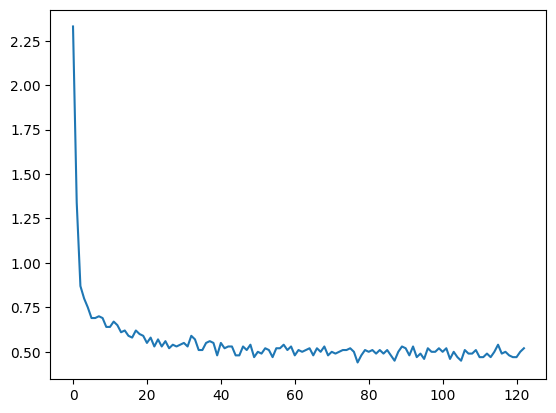

In [78]:
with open("defaults.log") as f:
    log = f.read()
losses = [float(v) for v in re.findall('mean loss (.*) \|', log)]
plt.plot(losses)

In [77]:
with open("defaults_k_aggregate_2_batch_size_128.log") as f:
    log = f.read()
losses_agg_2 = [float(v) for v in re.findall('mean loss (.*) \|', log)]

<>:3: DeprecationWarning: invalid escape sequence \|
<>:3: DeprecationWarning: invalid escape sequence \|
<>:3: DeprecationWarning: invalid escape sequence \|
/tmp/ipykernel_3014563/3714644116.py:3: DeprecationWarning: invalid escape sequence \|
  losses_agg_2 = [float(v) for v in re.findall('mean loss (.*) \|', log)]


In [75]:
with open("lr_00001.log") as f:
    log = f.read()
losses_lr00001 = [float(v) for v in re.findall(r'mean loss (.*) \|', log)]

In [153]:
import torch
import math
d_per_feature = 3 
x = torch.zeros(100, 10)
pe = torch.zeros(*x.shape, d_per_feature)
#position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
interval_size = 10
div_term = (1./interval_size) * 2*math.pi*torch.exp(torch.arange(0, d_per_feature, 2).float()*math.log(math.sqrt(2)))
#print(div_term/2/math.pi)
pe[..., 0::2] = torch.sin(x.unsqueeze(-1) * div_term)
pe[..., 1::2] = torch.cos(x.unsqueeze(-1) * div_term)

RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 2.  Target sizes: [100, 10, 1].  Tensor sizes: [100, 10, 2]

In [155]:
torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
